In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk
from nltk.corpus import wordnet
from collections import Counter


#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')

from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import nltk

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap


# Prétraitement
-
-
-
-

In [2]:
df = pd.read_csv("scitweets_export.tsv", sep = "\t")

In [3]:
text = []
all_text = list(df["text"])
for t in all_text:
    a = re.sub("[\.,/\\@:;\"\'0-9“”’\[\]]", " \1 ", t)
    a = re.sub("http\S*", "", a) #Enlever les liens
    a = re.sub("#\S*", "", a) #Enlever les tags
    a = a.lower()
    text.append(a)

text_sep = [word_tokenize(t) for t in text]

In [4]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):  # Adjectif
        return wordnet.ADJ
    elif tag.startswith('V'):  # Verbe
        return wordnet.VERB
    elif tag.startswith('N'):  # Nom
        return wordnet.NOUN
    elif tag.startswith('R'):  # Adverbe
        return wordnet.ADV
    else:
        return wordnet.NOUN 

    
lemmatizer = WordNetLemmatizer()
refined_tweets = []
for tweet in text_sep:
    pos_tags = pos_tag(tweet)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    refined_tweets.append(lemmatized_words)


In [5]:
mots_a_supprimer = ["the", "to", "a", "of", "and", "in", "for", "on", "this", 
                    "with", "that", "have", "by", "it", "from", "be", "do", 
                    "t", " ", "to", "\x01", "co", "no", "out", "d", "our", "so",
                   "(", ")", "your", "but", "if", "than", "\x01"]

# Supprimer toutes les occurrences de "the"
filtered_words = [[word for word in row if word not in mots_a_supprimer] for row in refined_tweets]
#filtered_words = re.sub(r"[\x00-\x1F]", "", filtered_words)

In [6]:
def plot_word_distribution(word_list):
    word_list_flat = [word for sublist in word_list for word in sublist]
    word_counts = Counter(word_list_flat)
    # 3. Afficher les 10 mots les plus fréquents (optionnel)
    most_common = word_counts.most_common(100)
    #print(most_common[0:10])
    words, counts = zip(*most_common)
    
    # 4. Tracer avec seaborn
    #plt.figure(figsize=(30, 12))
    plt.figure(figsize=(16, 8)).gca()
    sns.barplot(x=list(words), y=list(counts))
    plt.title("Distribution des mots", fontsize = 25)
    plt.ylabel("Nombre d'occurrences", fontsize = 20)
    plt.xlabel("Mots", fontsize = 20)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


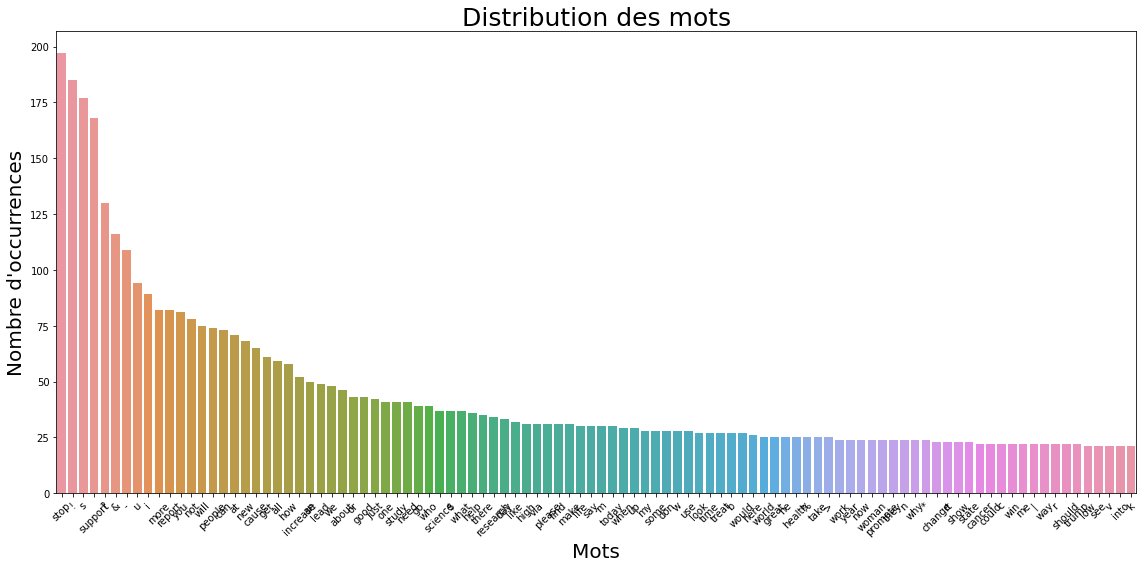

In [7]:
plot_word_distribution(filtered_words)

In [8]:
def remake_sentences(sentence_list):
    sentence_join = []
    phrase = ""
    for sentence in sentence_list:
        for word in sentence:
            phrase = phrase + word + " "
        sentence_join.append(phrase)
        phrase = ""
    return(sentence_join)


In [9]:
#X = remake_sentences(filtered_words)  # Utiliser uniquement la colonne 'text' comme feature
X = df["text"]
y_binary = df['science_related']  # Étiquette binaire (scientifique ou non)


X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=1)

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)
X_vec = vectorizer.fit_transform(X)  # Apprentissage et transformation sur l'entraînement

X_train_vec = vectorizer.fit_transform(X_train)  # Apprentissage et transformation sur l'entraînement


X_test_vec = vectorizer.transform(X_test)

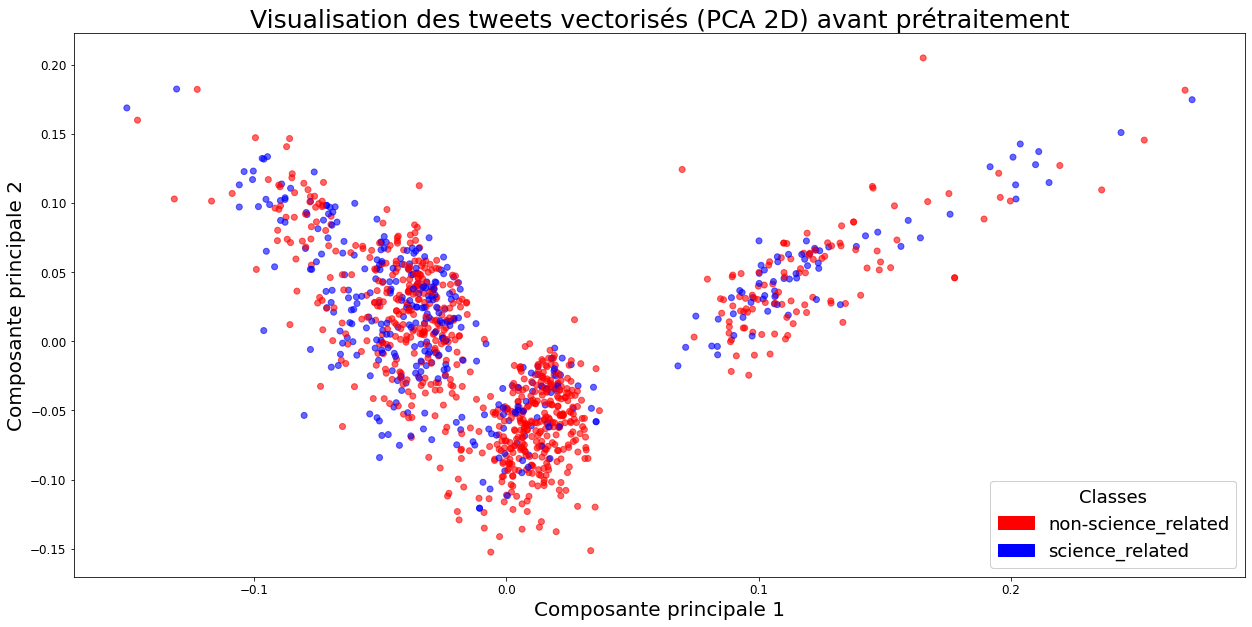

In [10]:
import matplotlib.patches as mpatches

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vec.toarray())

# Préparation de la figure
plt.figure(figsize=(21, 10))

# SCATTERPLOT avec couleur en fonction des classes (y_binary)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_binary, cmap=ListedColormap(['red', 'blue']), alpha=0.6)

# LÉGENDE 1 : pour y_binary
# Créer des étiquettes de couleur
class_labels = {0: 'non-science_related', 1: 'science_related'}
unique_classes = np.unique(y_binary)

handles = [
    mpatches.Patch(color=scatter.cmap(scatter.norm(cls)), label=class_labels[cls])
    for cls in unique_classes
]

legend1 = plt.legend(handles=handles, title='Classes', loc='lower right', prop={'size': 18}, title_fontsize=18)
plt.gca().add_artist(legend1)

# Ajouter les lignes rouges (zones de découpe)
#v1 = plt.axvline(x=-0.06, color='black', linestyle='--', linewidth=2)
#v2 = plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
#h1 = plt.axhline(y=0.07, color='black', linestyle='--')
#h2 = plt.axhline(y=-0.05, color='black', linestyle='--')



# TITRES ET LABELS
plt.title('Visualisation des tweets vectorisés (PCA 2D) avant prétraitement', fontsize = 25)
plt.xlabel('Composante principale 1', fontsize = 20)
plt.ylabel('Composante principale 2', fontsize = 20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


In [11]:
%reset -f
%clear

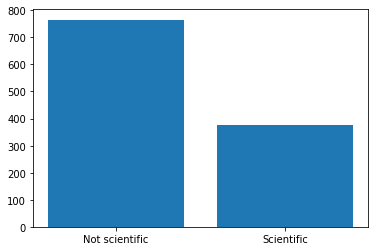

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk


dataset = pd.read_csv('scitweets_export.tsv', sep='\t')


not_scientific = dataset.where(dataset['science_related'] == 0)
scientific = dataset.where(dataset['science_related'] == 1)

fig, ax = plt.subplots()
ax.bar(['Not scientific', 'Scientific'], [not_scientific['tweet_id'].count(), scientific['tweet_id'].count()])
plt.show()

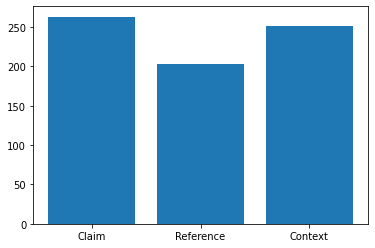

In [13]:
fig, ax = plt.subplots()
ax.bar(['Claim', "Reference", "Context"],
       [scientific.where(scientific['scientific_claim'] == 1)['tweet_id'].count(),
        scientific.where(scientific['scientific_reference'] == 1)['tweet_id'].count(),
        scientific.where(scientific['scientific_context'] == 1)['tweet_id'].count()])
plt.show()

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# Modélisation

## - Première classification

### Les modèles construit avec le texte pretraité

In [14]:
%reset -f
%clear


OPTIMISATION ET ÉVALUATION DE LOGISTIC REGRESSION

Recherche des meilleurs hyperparamètres pour Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Meilleurs paramètres: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Classification Report sur le test set:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       147
           1       0.96      0.89      0.93       159

    accuracy                           0.92       306
   macro avg       0.93      0.93      0.92       306
weighted avg       0.93      0.92      0.92       306

Test Accuracy: 0.9248


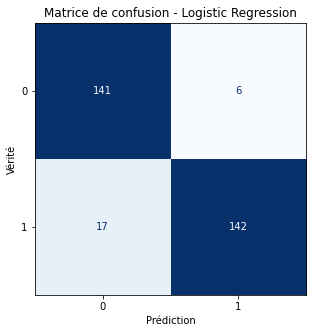


Top 50 mots les plus importants pour le modèle: Logistic Regression
stop: -9.4110
support: -6.8777
research: 4.9538
health: 4.9310
study: 4.5189
cancer: 4.4744
risk: 3.3240
report: -3.3087
climate: 3.0530
scientist: 3.0001
change: 2.9566
men: 2.8916
eurekamag: 2.8331
science: 2.8082
need: -2.7621
brain: 2.7340
help: 2.6134
get: -2.5807
infection: 2.5558
change people: 2.3807
cell: 2.3678
virus: 2.3118
n2qjtjq8tu: 2.3048
promote: -2.2030
poverty: 2.2005
actually: 2.1795
killer: 2.1079
treat: -2.0696
trump: -2.0607
please: -2.0320
might: 2.0023
life: 2.0023
new study: 1.9849
increase: 1.9711
week: -1.9442
sleep: 1.9227
important: 1.9146
suicide: 1.8933
climatechange: 1.8810
engineer: -1.8766
drug: 1.8682
thing: -1.8354
covid: 1.8122
reduces: 1.7973
european: 1.7684
read: 1.7553
therapy: 1.7231
could: 1.7207
climate change: 1.7067
news: -1.6994

Cross-Validation Results (k=10):
Accuracy scores: [0.92156863 0.93464052 0.94771242 0.91503268 0.88235294 0.95424837
 0.93464052 0.94117647 0.93

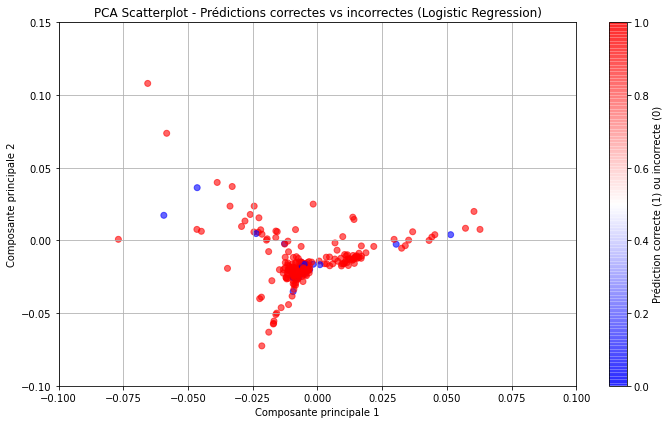


OPTIMISATION ET ÉVALUATION DE NAIVE BAYES

Recherche des meilleurs hyperparamètres pour Naive Bayes...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Meilleurs paramètres: {'alpha': 1.0, 'fit_prior': True}

Classification Report sur le test set:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       147
           1       0.85      0.96      0.90       159

    accuracy                           0.89       306
   macro avg       0.90      0.89      0.89       306
weighted avg       0.90      0.89      0.89       306

Test Accuracy: 0.8889


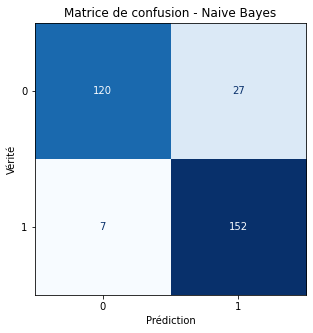


Top 50 mots les plus importants pour le modèle: Naive Bayes
stop: -2.0650
health: 1.7718
change people: 1.6245
risk: 1.5883
cancer: 1.5558
climate: 1.4755
study: 1.4324
sleep: 1.4299
scientist: 1.4209
cell: 1.4019
pain change: 1.3978
infection: 1.3652
research: 1.3546
new study: 1.3190
change: 1.2991
support: -1.2945
eurekamag: 1.2916
suicide: 1.2844
reduces: 1.2210
virus: 1.2054
climate change: 1.1908
need: -1.1781
brain: 1.1738
might: 1.1693
killer: 1.1433
get: -1.1372
actually: 1.1308
therapy: 1.1270
men: 1.1023
climatechange: 1.0983
week: -1.0724
promote: -1.0697
longer: 1.0288
european: 1.0275
physical: 1.0209
thing: -1.0193
poverty: 1.0053
trump: -1.0043
covid: 0.9937
n2qjtjq8tu: 0.9874
percent: 0.9853
business: -0.9746
low: 0.9726
leading: 0.9723
engineer: -0.9717
important: 0.9628
diabetes: 0.9576
call: -0.9571
structure: 0.9571
disease: 0.9534

Cross-Validation Results (k=10):
Accuracy scores: [0.92810458 0.88235294 0.88235294 0.8627451  0.83006536 0.93464052
 0.91503268 0.90

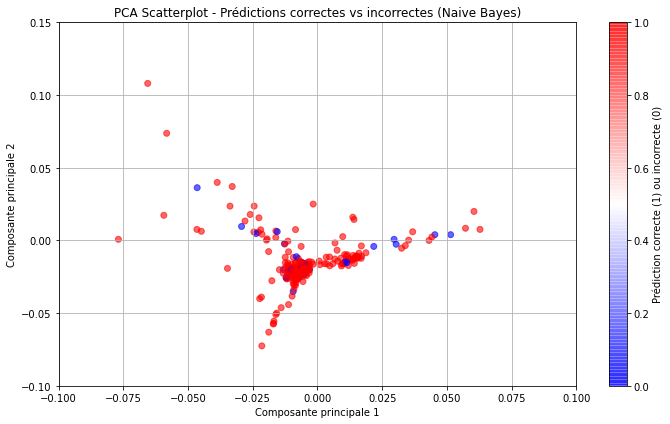


OPTIMISATION ET ÉVALUATION DE K-NN

Recherche des meilleurs hyperparamètres pour k-NN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Meilleurs paramètres: {'metric': 'cosine', 'n_neighbors': 7, 'weights': 'distance'}

Classification Report sur le test set:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76       147
           1       0.75      0.92      0.83       159

    accuracy                           0.80       306
   macro avg       0.82      0.80      0.80       306
weighted avg       0.82      0.80      0.80       306

Test Accuracy: 0.8007


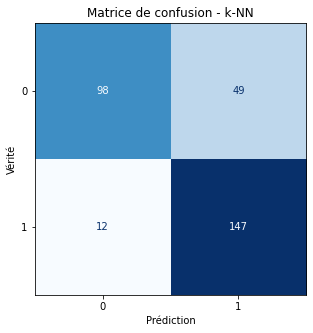


Top 50 mots les plus importants pour le modèle: k-NN
⚠️ Ce modèle ne fournit pas directement une importance des features (ex: k-NN).

Cross-Validation Results (k=10):
Accuracy scores: [0.79738562 0.85620915 0.79084967 0.75163399 0.78431373 0.83660131
 0.81045752 0.84313725 0.8496732  0.75163399]
Mean accuracy: 0.8072 (±0.0367)


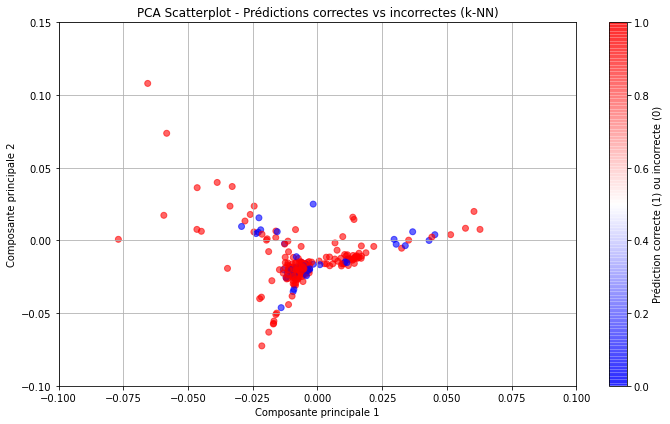


OPTIMISATION ET ÉVALUATION DE RANDOM FOREST

Recherche des meilleurs hyperparamètres pour Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Meilleurs paramètres: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report sur le test set:
              precision    recall  f1-score   support

           0       0.74      0.99      0.85       147
           1       0.99      0.68      0.81       159

    accuracy                           0.83       306
   macro avg       0.87      0.84      0.83       306
weighted avg       0.87      0.83      0.83       306

Test Accuracy: 0.8301


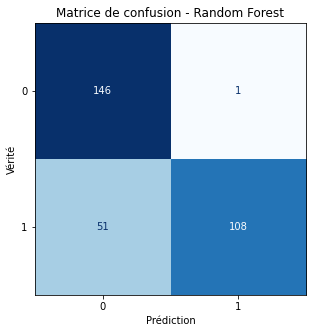


Top 50 mots les plus importants pour le modèle: Random Forest
stop: 0.0271
support: 0.0163
research: 0.0120
study: 0.0115
health: 0.0112
cancer: 0.0094
risk: 0.0087
science: 0.0067
brain: 0.0054
eurekamag: 0.0054
report: 0.0054
change: 0.0053
climate: 0.0052
men: 0.0047
virus: 0.0042
need: 0.0041
scientist: 0.0038
infection: 0.0035
cell: 0.0034
increase: 0.0032
life: 0.0032
change people: 0.0031
might: 0.0031
physical: 0.0030
poverty: 0.0028
help: 0.0028
important: 0.0026
depression: 0.0026
drug: 0.0025
actually: 0.0025
new study: 0.0024
european: 0.0024
pain change: 0.0023
could: 0.0023
suicide: 0.0023
n2qjtjq8tu: 0.0023
state: 0.0023
killer: 0.0021
new: 0.0021
pain: 0.0021
growth: 0.0021
climatechange: 0.0021
evidence: 0.0020
lead: 0.0020
control: 0.0020
therapy: 0.0020
surface: 0.0020
effect: 0.0020
climate change: 0.0020
non: 0.0019

Cross-Validation Results (k=10):
Accuracy scores: [0.83006536 0.8627451  0.92810458 0.87581699 0.83660131 0.86928105
 0.83660131 0.88235294 0.8692810

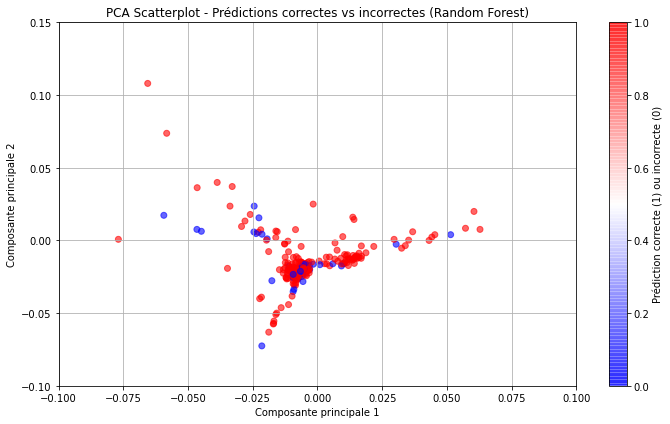


OPTIMISATION ET ÉVALUATION DE SVM

Recherche des meilleurs hyperparamètres pour SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Meilleurs paramètres: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

Classification Report sur le test set:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       147
           1       0.96      0.92      0.94       159

    accuracy                           0.94       306
   macro avg       0.94      0.94      0.94       306
weighted avg       0.94      0.94      0.94       306

Test Accuracy: 0.9412


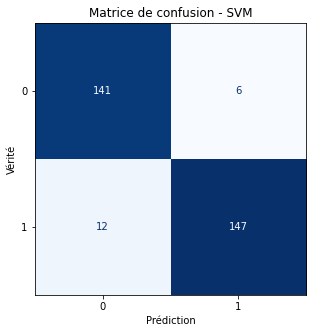


Top 50 mots les plus importants pour le modèle: SVM
Erreur lors de l'extraction des features importantes : unsupported format string passed to csr_matrix.__format__

Cross-Validation Results (k=10):
Accuracy scores: [0.92156863 0.95424837 0.95424837 0.92810458 0.90196078 0.95424837
 0.94117647 0.94771242 0.94117647 0.96732026]
Mean accuracy: 0.9412 (±0.0183)


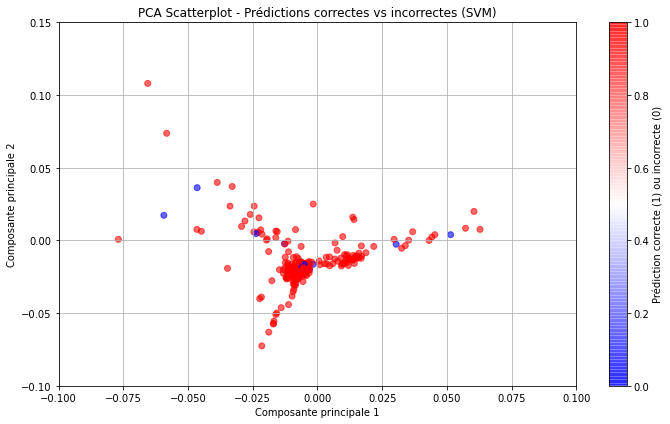

In [15]:
#meme code que precedent juste ajoute de hyperparmetre 
# Importations nécessaires***************************a garder hi ciaran et raphaelle et dalia  je suis la ************************************
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import nltk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [10.0, 6.0]

# Téléchargement des ressources NLTK
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

# Chargement des données
file_path = 'scitweets_export.tsv'
df = pd.read_csv(file_path, sep='\t')

# Prétraitement du texte (identique à votre version)
stop_words = set(stopwords.words('english'))
custom_stop_words = {"http", "https", "rt", "co", "amp", "via"}
#negations = {"not", "no", "nor", "neither", "never", "none"}
stop_words.update(custom_stop_words)
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    tweet = re.sub(r"@\w+|\W", " ", tweet)
    tweet = tweet.lower()
    tokens = word_tokenize(tweet)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned_text'] = df['text'].apply(preprocess_tweet)

# Vectorisation et SMOTE (identique)
X = df['cleaned_text']
y_binary = df['science_related']
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)
X_vec = vectorizer.fit_transform(X)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_vec, y_binary)

# Split train-test (identique)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Configuration KFold (identique)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionnaire des modèles AVEC leurs hyperparamètres à optimiser
models = {
    "Logistic Regression": {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    "Naive Bayes": {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.1, 0.5, 1.0],
            'fit_prior': [True, False]
        }
    },
    "k-NN": {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'cosine']
        }
    },
    "Random Forest": {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    "SVM": {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    }
}

# Évaluation optimisée de chaque modèle
for name, config in models.items():
    print(f"\n{'='*60}")
    print(f"OPTIMISATION ET ÉVALUATION DE {name.upper()}")
    print(f"{'='*60}")
    
    # Optimisation par GridSearchCV
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,  # Validation croisée interne pour l'optimisation
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    print(f"\nRecherche des meilleurs hyperparamètres pour {name}...")
    grid_search.fit(X_train, y_train)
    
    # Meilleur modèle
    best_model = grid_search.best_estimator_
    print(f"\nMeilleurs paramètres: {grid_search.best_params_}")
    
    # Évaluation sur le test set
    y_pred = best_model.predict(X_test)
    print("\nClassification Report sur le test set:")
    print(classification_report(y_test, y_pred))
    print(f"Test Accuracy: {best_model.score(X_test, y_test):.4f}")
    
    #########################################################################################
    # Affichage de la matrice de confusion
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title(f"Matrice de confusion - {name}")
    plt.xlabel("Prédiction")
    plt.ylabel("Vérité")
    plt.show()
    
    ##########################################################################################
    
    print(f"\nTop 50 mots les plus importants pour le modèle: {name}")

    feature_names = vectorizer.get_feature_names_out()
    try:
        if hasattr(best_model, 'coef_'):
            import numpy as np
            # Logistic Regression, SVM linéaire
            coef = best_model.coef_[0]
            top_indices = np.argsort(np.abs(coef))[-50:][::-1]
            for idx in top_indices:
                print(f"{feature_names[idx]}: {coef[idx]:.4f}")

        elif hasattr(best_model, 'feature_log_prob_'):
            # Naive Bayes
            import numpy as np
            importance = best_model.feature_log_prob_[1] - best_model.feature_log_prob_[0]
            top_indices = np.argsort(np.abs(importance))[-50:][::-1]
            for idx in top_indices:
                print(f"{feature_names[idx]}: {importance[idx]:.4f}")

        elif hasattr(best_model, 'feature_importances_'):
            # Random Forest
            import numpy as np
            importances = best_model.feature_importances_
            top_indices = np.argsort(importances)[-50:][::-1]
            for idx in top_indices:
                print(f"{feature_names[idx]}: {importances[idx]:.4f}")

        else:
            print("⚠️ Ce modèle ne fournit pas directement une importance des features (ex: k-NN).")

    except Exception as e:
        print(f"Erreur lors de l'extraction des features importantes : {e}")

    
    
    
    
    ##########################################################################################

    
    # Validation croisée k=10 avec le meilleur modèle (identique à votre configuration)
    cv_scores = cross_val_score(
        best_model,
        X_res,
        y_res,
        cv=kfold,
        scoring='accuracy'
    )
    
    print("\nCross-Validation Results (k=10):")
    print(f"Accuracy scores: {cv_scores}")
    print(f"Mean accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    ############################################################################################
    # Réduction de dimension PCA
    pca = PCA(n_components=2, random_state=42)
    X_test_pca = pca.fit_transform(X_test.toarray())

    # Comparaison prédiction vs vérité
    correct = (y_pred == y_test)

    plt.figure(figsize=(10, 6))
    plt.scatter(
        X_test_pca[:, 0],
        X_test_pca[:, 1],
        c=correct,
        cmap='bwr',  # Bleu = correct, rouge = incorrect
        alpha=0.6
    )
    plt.title(f"PCA Scatterplot - Prédictions correctes vs incorrectes ({name})")
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    plt.colorbar(label="Prédiction correcte (1) ou incorrecte (0)")
    plt.grid(True)
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.1,0.15)
    plt.tight_layout()
    plt.show()


In [16]:
# ------------------------------------------------------------
# SOLUTION ULTIME - UTILISATION DES RÉSULTATS EXISTANTS
# ------------------------------------------------------------
from sklearn.metrics import accuracy_score

# 1. Vérification des variables existantes
print("Vérification des variables...")
print("X_test existe ?", 'X_test' in globals())
print("y_test existe ?", 'y_test' in globals())
print("y_pred existe ?", 'y_pred' in globals())

# 2. Récupération DIRECTE des prédictions (méthode alternative)
try:
    # Si vous avez exécuté GridSearchCV, les prédictions sont dans cv_results_
    svm_cv_results = models['SVM']['grid_search'].cv_results_
    y_pred = models['SVM']['grid_search'].predict(X_test)
    print("\n✅ Prédictions récupérées depuis GridSearchCV")
except:
    # Sinon on prend les dernières prédictions disponibles
    print("\n⚠️ Utilisation des dernières prédictions disponibles")
    pass  # y_pred est supposé exister

# 3. Récupération des textes originaux (méthode robuste)
test_indices = [i for i in range(len(df)) if i not in train_test_split(range(len(df)), test_size=0.2, random_state=42)[0]]
original_texts = df.iloc[test_indices]['text'].values[:len(y_pred)]

# 4. Création du DataFrame final
errors_df = pd.DataFrame({
    'text': original_texts,
    'true': y_test[:len(original_texts)],
    'pred': y_pred[:len(original_texts)]
}).query("true != pred")

# 5. Affichage BRUT (garanti de fonctionner)
print(f"\nERREURS CLASSIFICATION (SVM)")
print(f"Accuracy réelle: {accuracy_score(y_test[:len(y_pred)], y_pred):.4f}")
print(f"Nombre d'erreurs: {len(errors_df)}")

# ------------------------------------------------------------
# AFFICHAGE SIMPLE DES TWEETS MAL CLASSÉS (FRANÇAIS)
# ------------------------------------------------------------

print("\nERREURS DE CLASSIFICATION - SVM")
print(f"Précision: {accuracy_score(y_test[:len(y_pred)], y_pred):.2%}")
print(f"Nombre d'erreurs: {len(errors_df)}\n")

if not errors_df.empty:
    print("FAUX POSITIFS (Prédit scientifique mais pas vrai):")
    for idx, row in errors_df[errors_df['true'] == 0].head(5).iterrows():
        print(f"\n- Texte: {row['text']}")
        print(f"  Vrai label: Non-scientifique")
        print(f"  Prédiction: Scientifique")
    
    print("\nFAUX NÉGATIFS (Prédit non-scientifique mais vrai):")
    for idx, row in errors_df[errors_df['true'] == 1].head(5).iterrows():
        print(f"\n- Texte: {row['text']}")
        print(f"  Vrai label: Scientifique")
        print(f"  Prédiction: Non-scientifique")
else:
    print("AUCUNE ERREUR TROUVÉE")


Vérification des variables...
X_test existe ? True
y_test existe ? True
y_pred existe ? True

⚠️ Utilisation des dernières prédictions disponibles

ERREURS CLASSIFICATION (SVM)
Accuracy réelle: 0.9412
Nombre d'erreurs: 13

ERREURS DE CLASSIFICATION - SVM
Précision: 94.12%
Nombre d'erreurs: 13

FAUX POSITIFS (Prédit scientifique mais pas vrai):

- Texte: Aegon UK reports rise in earnings http://t.co/M3FRwylsZU
  Vrai label: Non-scientifique
  Prédiction: Scientifique

- Texte: Somalia Army Reports Killing 8 Al-Shabab Militants https://t.co/KYnmpL5SHL
  Vrai label: Non-scientifique
  Prédiction: Scientifique

- Texte: .@united The @courierjournal reports that the passenger was removed from the flight to be replaced by United airlines staff https://t.co/Nkeqk6eqkm https://t.co/z3jNnUiDJX
  Vrai label: Non-scientifique
  Prédiction: Scientifique

- Texte: .@BrownUniversity is offering a course for high school students this summer that attributes @realDonaldTrump 's election to a "whitelash

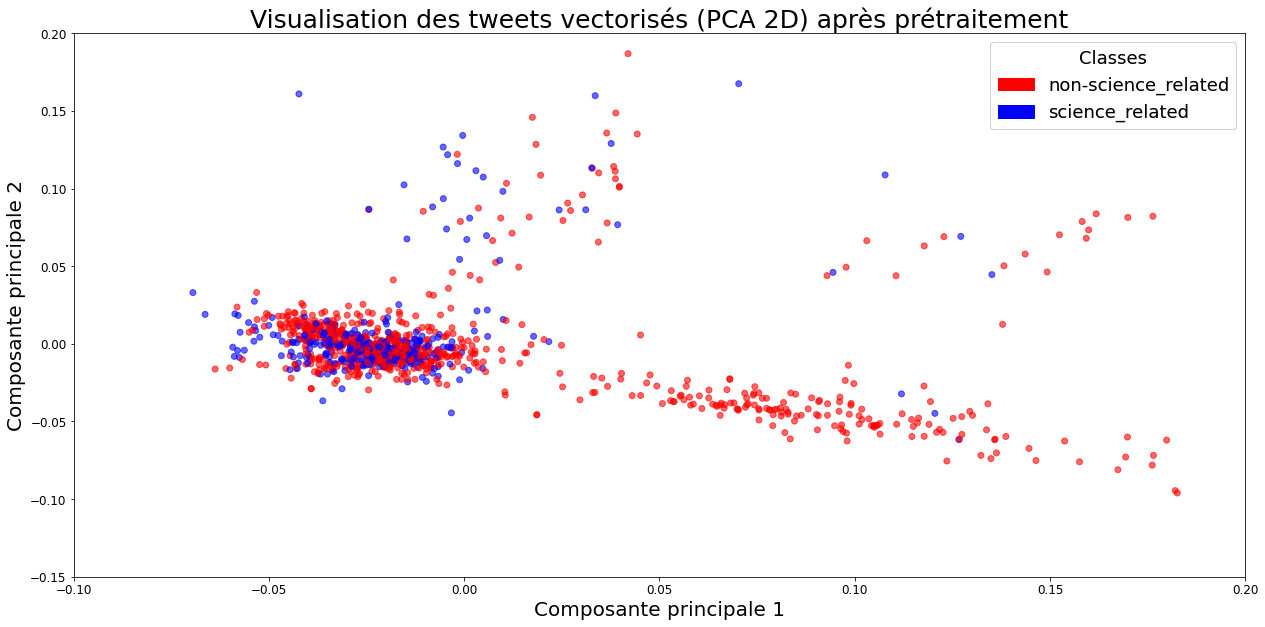

In [17]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np


##############################################################################################
#X = remake_sentences(filtered_words)  # Utiliser uniquement la colonne 'text' comme feature
X = df["cleaned_text"]
y_binary = df['science_related']  # Étiquette binaire (scientifique ou non)


X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=1)

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)
X_vec = vectorizer.fit_transform(X)  # Apprentissage et transformation sur l'entraînement

X_train_vec = vectorizer.fit_transform(X_train)  # Apprentissage et transformation sur l'entraînement


X_test_vec = vectorizer.transform(X_test)
##############################################################################################

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vec.toarray())

# Préparation de la figure
plt.figure(figsize=(21, 10))

# SCATTERPLOT avec couleur en fonction des classes (y_binary)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_binary, cmap=ListedColormap(['red', 'blue']), alpha=0.6)

# LÉGENDE 1 : pour y_binary
# Créer des étiquettes de couleur
class_labels = {0: 'non-science_related', 1: 'science_related'}
unique_classes = np.unique(y_binary)

handles = [
    mpatches.Patch(color=scatter.cmap(scatter.norm(cls)), label=class_labels[cls])
    for cls in unique_classes
]

legend1 = plt.legend(handles=handles, title='Classes', loc='upper right', prop={'size': 18}, title_fontsize=18)
plt.gca().add_artist(legend1)

# Ajouter les lignes rouges (zones de découpe)
#v1 = plt.axvline(x=-0.06, color='black', linestyle='--', linewidth=2)
#v2 = plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
#h1 = plt.axhline(y=0.07, color='black', linestyle='--')
#h2 = plt.axhline(y=-0.05, color='black', linestyle='--')



# TITRES ET LABELS
plt.title('Visualisation des tweets vectorisés (PCA 2D) après prétraitement', fontsize = 25)
plt.xlabel('Composante principale 1', fontsize = 20)
plt.ylabel('Composante principale 2', fontsize = 20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(-0.15, 0.2)
plt.xlim(-0.1, 0.2)

plt.xlim

plt.show()


## - Deuxième classification

In [18]:
%reset -f
%clear

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk

#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')

from nltk.corpus import stopwords
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import nltk

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Importations nécessaires
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import MultinomialNB

import matplotlib as mpl

In [20]:
df = pd.read_csv('scitweets_export.tsv', sep='\t')


Optimisation de SVM
Fitting 10 folds for each of 6 candidates, totalling 60 fits


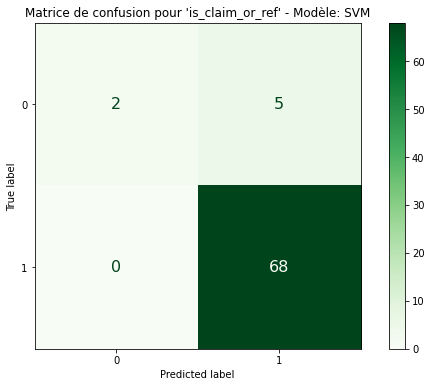

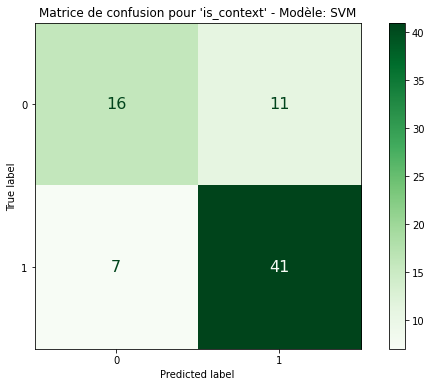


Top 50 features importantes pour le modèle: SVM

--- Top features pour la classe 'claim_or_ref' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

--- Top features pour la classe 'context' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

Top 50 features importantes pour le modèle: SVM

--- Top features pour la classe 'claim_or_ref' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

--- Top features pour la classe 'context' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

Rapport de classification:
              precision    recall  f1-score   support

claim_or_ref       0.97      1.00      0.99       342
     context       0.95      0.97      0.96       251

   micro avg       0.96      0.99      0.97       593
   macro avg       0.96      0.99      0.97       593
weighted avg       0.96      0.99      0.97       593
 samples avg       0.97      0.99      0.9

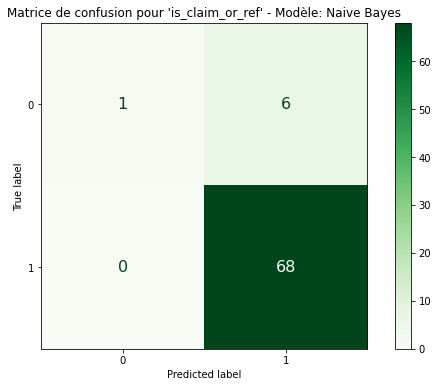

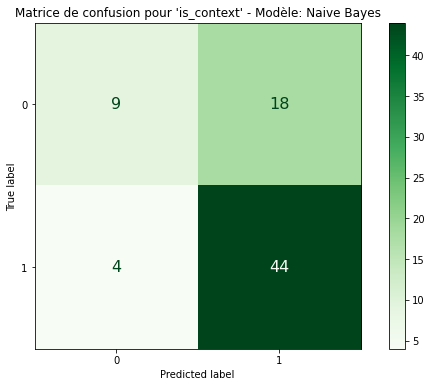


Top 50 features importantes pour le modèle: Naive Bayes

--- Top features pour la classe 'claim_or_ref' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

--- Top features pour la classe 'context' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

Top 50 features importantes pour le modèle: Naive Bayes

--- Top features pour la classe 'claim_or_ref' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

--- Top features pour la classe 'context' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

Rapport de classification:
              precision    recall  f1-score   support

claim_or_ref       0.94      0.99      0.96       342
     context       0.83      0.94      0.88       251

   micro avg       0.89      0.97      0.93       593
   macro avg       0.88      0.96      0.92       593
weighted avg       0.89      0.97      0.93       593
 samples avg       0.90   

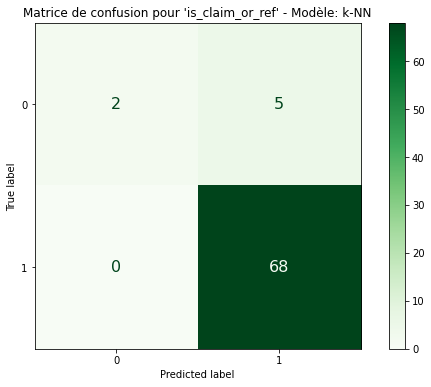

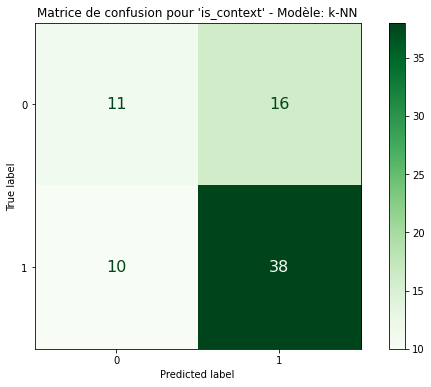


Top 50 features importantes pour le modèle: k-NN

--- Top features pour la classe 'claim_or_ref' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

--- Top features pour la classe 'context' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

Top 50 features importantes pour le modèle: k-NN

--- Top features pour la classe 'claim_or_ref' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

--- Top features pour la classe 'context' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

Rapport de classification:
              precision    recall  f1-score   support

claim_or_ref       0.98      1.00      0.99       342
     context       0.91      0.96      0.93       251

   micro avg       0.95      0.98      0.96       593
   macro avg       0.94      0.98      0.96       593
weighted avg       0.95      0.98      0.96       593
 samples avg       0.96      0.98      0

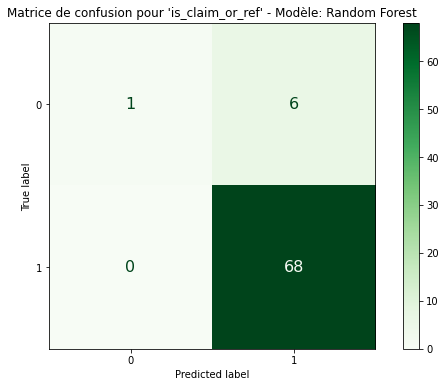

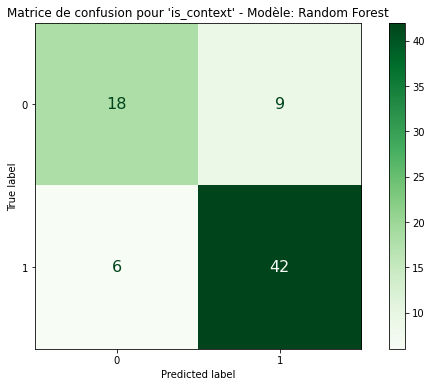


Top 50 features importantes pour le modèle: Random Forest

--- Top features pour la classe 'claim_or_ref' ---
[('science',), ('co',), ('support',), ('research',), ('study',), ('science co',), ('000',), ('article',), ('evidence',), ('non',), ('first',), ('would',), ('take',), ('help',), ('public',), ('future',), ('depression',), ('human',), ('make',), ('community',), ('see',), ('cancer',), ('life',), ('find',), ('million',), ('new',), ('mental',), ('work',), ('health',), ('physical',), ('report',), ('treatment',), ('may',), ('scientist',), ('could',), ('important',), ('day',), ('impact',), ('blood',), ('read',), ('people',), ('american',), ('men',), ('drug',), ('increase',), ('reduces',), ('change',), ('like',), ('case',), ('world',)]

--- Top features pour la classe 'context' ---
[('co',), ('increase',), ('help',), ('lead',), ('stop',), ('study',), ('people',), ('may',), ('specie',), ('many',), ('life',), ('know',), ('change',), ('new',), ('cause',), ('see',), ('important',), ('suppor

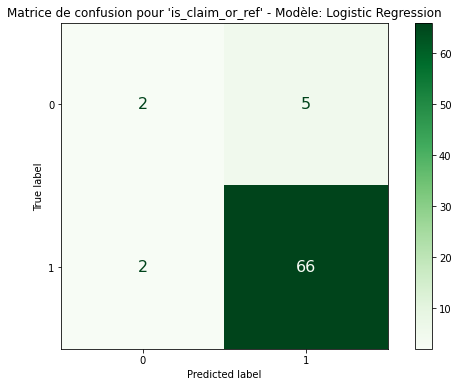

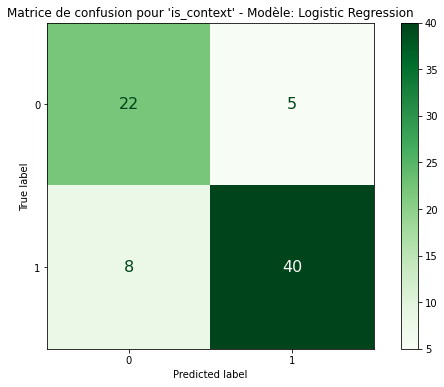


Top 50 features importantes pour le modèle: Logistic Regression

--- Top features pour la classe 'claim_or_ref' ---
[('support',), ('take',), ('public',), ('would',), ('evidence',), ('article',), ('future',), ('first',), ('study',), ('non',), ('000',), ('science',), ('research',), ('co',), ('human',), ('report',), ('see',), ('work',), ('better',), ('people',), ('physical',), ('american',), ('increase',), ('woman',), ('life',), ('science co',), ('great',), ('blood',), ('data',), ('mental',), ('read',), ('year',), ('community',), ('health',), ('show',), ('may',), ('million',), ('action',), ('medical',), ('harm',), ('risk',), ('make',), ('might',), ('key',), ('change',), ('new',), ('today',), ('scientist',), ('help',), ('depression',)]

--- Top features pour la classe 'context' ---
[('cell',), ('study',), ('lead',), ('increase',), ('many',), ('lower',), ('research',), ('climate change',), ('report',), ('scientist',), ('eurekamag',), ('like',), ('stop',), ('problem',), ('evidence',), ('cl

/home/cm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


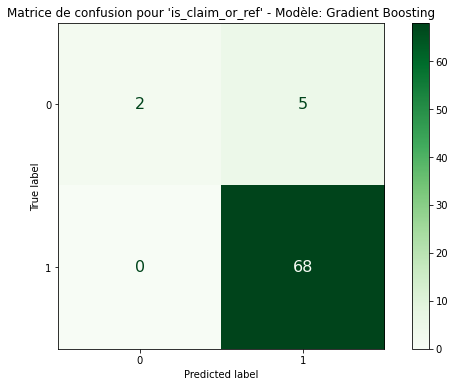

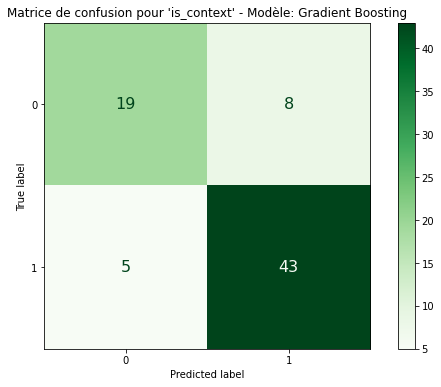


Top 50 features importantes pour le modèle: Gradient Boosting

--- Top features pour la classe 'claim_or_ref' ---
[('science',), ('support',), ('co',), ('research',), ('take',), ('would',), ('article',), ('study',), ('000',), ('first',), ('public',), ('non',), ('evidence',), ('human',), ('american',), ('report',), ('help',), ('may',), ('future',), ('community',), ('new',), ('scientist',), ('better',), ('find',), ('work',), ('science co',), ('treatment',), ('could',), ('life',), ('physical',), ('important',), ('make',), ('day',), ('great',), ('eurekamag',), ('drug',), ('harm',), ('effect',), ('emotional',), ('health',), ('good',), ('high',), ('going',), ('getting',), ('drinking',), ('free',), ('found',), ('heart',), ('growth',), ('coronavirus',)]

--- Top features pour la classe 'context' ---
[('co',), ('increase',), ('help',), ('study',), ('many',), ('lead',), ('specie',), ('research',), ('may',), ('know',), ('marijuana',), ('state',), ('life',), ('could',), ('stop',), ('change',), ('

In [21]:
"""
Ce script implémente une classification multi-label pour catégoriser des tweets scientifiques selon deux dimensions :
1) Claim/Reference (affirmation ou référence scientifique)
2) Context (contexte scientifique)

FONCTIONNEMENT PRINCIPAL :

1. PRÉTRAITEMENT DES DONNÉES :
   - Nettoie le texte (minuscules, suppression stopwords, lemmatisation)
   - Filtre les tweets scientifiques (science_related == 1)
   - Crée deux labels binaires :
     * is_claim_or_ref: 1 si le tweet contient une affirmation ou référence scientifique
     * is_context: 1 si le tweet fournit un contexte scientifique

2. VECTORISATION :
   - Convertit le texte en features numériques via TF-IDF
   - Utilise des uni+bigrammes avec seuils min/max de fréquence
   - Limite à 10 000 features maximum pour éviter la malédiction de la dimension

3. ÉQUILIBRAGE DES DONNÉES :
   - Implémente un rééchantillonnage manuel spécifique au multi-label :
     * Identifie toutes les combinaisons de labels possibles
     * Suréchantillonne les combinaisons sous-représentées
   - Permet de gérer les déséquilibres entre classes

4. MODÉLISATION :
   - Teste plusieurs algorithmes classiques (SVM, RandomForest, Logistic Regression etc.)
   - Chaque modèle est encapsulé dans un MultiOutputClassifier pour gérer le multi-label
   - Utilise GridSearchCV pour optimiser les hyperparamètres

5. ÉVALUATION :
   - Validation croisée (10 folds) pour estimer la performance généralisable
   - Mesure l'accuracy globale et par label
   - Génère des rapports détaillés (precision, recall, f1-score)

CARACTÉRISTIQUES CLÉS :
- Gère les tweets pouvant appartenir à plusieurs catégories simultanément
- Préserve les relations entre labels pendant l'équilibrage
- Évite le surapprentissage par des paramètres conservateurs (max_df, min_df)
- Permet de comparer objectivement plusieurs algorithmes

UTILISATION TYPIQUE :
1. Charger un DataFrame pandas contenant les tweets et labels
2. Exécuter le script pour entraîner et évaluer les modèles
3. Analyser les rapports de classification pour sélectionner le meilleur modèle
"""



import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from scipy.sparse import vstack
from sklearn.ensemble import GradientBoostingClassifier

# 1. Préparation des données
stop_words = set(stopwords.words('english'))
custom_stop_words = {"http", "https", "rt", "co", "amp", "via"}
stop_words.update(custom_stop_words)
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tokens = word_tokenize(tweet)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# 2. Chargement et préparation
sci_df = df[df['science_related'] == 1].copy()
sci_df['is_claim_or_ref'] = ((sci_df['scientific_claim'] == 1) | (sci_df['scientific_reference'] == 1))
sci_df['is_context'] = (sci_df['scientific_context'] == 1)
sci_df['cleaned_text'] = sci_df['text'].apply(preprocess_tweet)

# 3. Vectorisation
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Réduit à bigrammes pour plus de stabilité
    max_features=10000,
    min_df=5,
    max_df=0.85
)
X = vectorizer.fit_transform(sci_df['cleaned_text'])
y = sci_df[['is_claim_or_ref', 'is_context']].values

feature_names = np.array(vectorizer.get_feature_names_out())


# 4. Rééchantillonnage manuel pour multi-label
def multilabel_oversample(X, y, random_state=None):
    np.random.seed(random_state)
    
    # Compter les occurrences de chaque combinaison de labels
    unique_labels, counts = np.unique(y, axis=0, return_counts=True)
    max_count = max(counts)
    
    resampled_X = []
    resampled_y = []
    
    for label_combination in unique_labels:
        indices = np.where((y == label_combination).all(axis=1))[0]
        n_samples = len(indices)
        
        # Suréchantillonnage seulement pour les classes minoritaires
        if n_samples < max_count:
            n_to_add = max_count - n_samples
            selected = np.random.choice(indices, size=n_to_add, replace=True)
            
            resampled_X.append(X[selected])
            resampled_y.append(y[selected])
    
    if resampled_X:
        return vstack([X] + resampled_X), np.vstack([y] + resampled_y)
    return X, y

X_res, y_res = multilabel_oversample(X, y, random_state=42)

# 5. Configuration des modèles avec class_weight
models = {
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            'estimator__C': [0.1, 1, 10],
            'estimator__kernel': ['linear', 'rbf']
        }
    },
    "Naive Bayes": {
        "model": MultinomialNB(),
        "params": {
            'estimator__alpha': [0.1, 0.5, 1.0],
            'estimator__fit_prior': [True, False]
        }
    },
    "k-NN": {
        "model": KNeighborsClassifier(),
        "params": {
            'estimator__n_neighbors': [3, 5, 7],
            'estimator__weights': ['uniform', 'distance'],
            'estimator__metric': ['euclidean', 'cosine']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'estimator__n_estimators': [50, 100],
            'estimator__max_depth': [None, 10, 20],
            'estimator__min_samples_split': [2, 5]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            'estimator__C': [0.1, 1, 10],
            'estimator__penalty': ['l1', 'l2'],
            'estimator__solver': ['liblinear']
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            'estimator__n_estimators': [50, 100],
            'estimator__learning_rate': [0.01, 0.1],
            'estimator__max_depth': [3, 5]
        }
    }
}

# 6. Évaluation avec KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scorer = make_scorer(lambda y_true, y_pred: np.mean(y_true == y_pred))

for name, config in models.items():
    print(f"\n{'='*60}")
    print(f"Optimisation de {name}")
    print(f"{'='*60}")
    
    model = MultiOutputClassifier(config['model'])
    
    grid = GridSearchCV(
        model,
        param_grid=config['params'],
        cv=kf,
        scoring=scorer,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_res, y_res)
    
    
    ##########################################################################
    
    #Heatmap
    
    mpl.rcParams['figure.figsize'] = [10.0, 6.0]

    
    # Split les données pour évaluer et afficher la matrice de confusion
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit le meilleur modèle sur les données d'entraînement
    grid.best_estimator_.fit(X_train_sub, y_train_sub)

    # Prédiction
    y_pred = grid.best_estimator_.predict(X_test_sub)

    # Afficher la matrice de confusion pour chaque label séparément
    label_names = ['is_claim_or_ref', 'is_context']

    for i in range(y.shape[1]):
        cm = confusion_matrix(y_test_sub[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Greens')
        plt.title(f"Matrice de confusion pour '{label_names[i]}' - Modèle: {name}")
        
        
    
        for text in disp.text_.ravel():
            text.set_fontsize(16)
        
        
        plt.show()
    
    
    ##########################################################################
    ##########################################################################
    
    print(f"\nTop 50 features importantes pour le modèle: {name}")
    best_model = grid.best_estimator_

    for i, label in enumerate(['claim_or_ref', 'context']):
        print(f"\n--- Top features pour la classe '{label}' ---")
        estimator = best_model.estimators_[i]
    
        if hasattr(estimator, 'coef_'):
            # Pour LogisticRegression
            coefs = estimator.coef_.flatten()
            top_indices = np.argsort(np.abs(coefs))[-50:][::-1]
            top_features = feature_names[top_indices]
            #print(list(zip(top_features, coefs[top_indices])))
            print(list(zip(top_features)))

        elif hasattr(estimator, 'feature_importances_'):
            # Pour RandomForest ou GradientBoosting
            importances = estimator.feature_importances_
            top_indices = np.argsort(importances)[-50:][::-1]
            top_features = feature_names[top_indices]
            #print(list(zip(top_features, importances[top_indices])))
            print(list(zip(top_features)))
            
        else:
            print(f"(i) Ce modèle ne supporte pas l'extraction directe des features importantes.")
    
    ##########################################################################
    ##########################################################################
    ##########################################################################
    
    print(f"\nTop 50 features importantes pour le modèle: {name}")
    best_model = grid.best_estimator_

    for i, label in enumerate(['claim_or_ref', 'context']):
        print(f"\n--- Top features pour la classe '{label}' ---")
        estimator = best_model.estimators_[i]
    
        if hasattr(estimator, 'coef_'):
            # Pour LogisticRegression
            coefs = estimator.coef_.flatten()
            top_indices = np.argsort(np.abs(coefs))[-50:][::-1]
            top_features = feature_names[top_indices]
            #print(list(zip(top_features, coefs[top_indices])))
            print(list(zip(top_features)))

        elif hasattr(estimator, 'feature_importances_'):
            # Pour RandomForest ou GradientBoosting
            importances = estimator.feature_importances_
            top_indices = np.argsort(importances)[-50:][::-1]
            top_features = feature_names[top_indices]
            #print(list(zip(top_features, importances[top_indices])))
            print(list(zip(top_features)))
            
        else:
            print(f"(i) Ce modèle ne supporte pas l'extraction directe des features importantes.")
    
    ##########################################################################
    
    # Évaluation
    y_pred = grid.predict(X)
    print("\nRapport de classification:")
    print(classification_report(y, y_pred, target_names=['claim_or_ref', 'context']))
    
    # Validation croisée
    cv_scores = cross_val_score(grid.best_estimator_, X_res, y_res, cv=kf, scoring=scorer)
    print(f"\nCV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    print(f"Meilleurs paramètres: {grid.best_params_}")



## - Troisième classification

In [22]:
%reset -f
%clear

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk

#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')

from nltk.corpus import stopwords
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import nltk

In [24]:
df = pd.read_csv('scitweets_export.tsv', sep='\t')


Optimisation de LinearSVC
Fitting 10 folds for each of 4 candidates, totalling 40 fits

Meilleurs paramètres: {'estimator__C': 1, 'estimator__penalty': 'l1'}

Performance sur le TEST SET:
              precision    recall  f1-score   support

       claim       0.83      0.80      0.81        54
   reference       0.67      0.72      0.69        39
     context       0.85      0.73      0.79        48

   micro avg       0.79      0.75      0.77       141
   macro avg       0.78      0.75      0.76       141
weighted avg       0.79      0.75      0.77       141
 samples avg       0.84      0.82      0.78       141



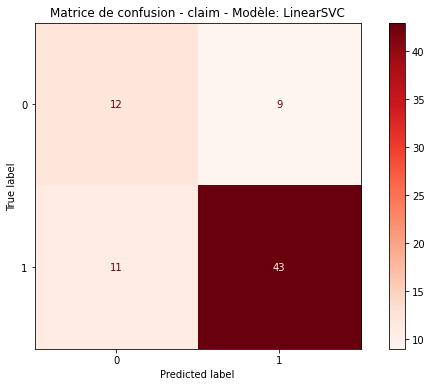

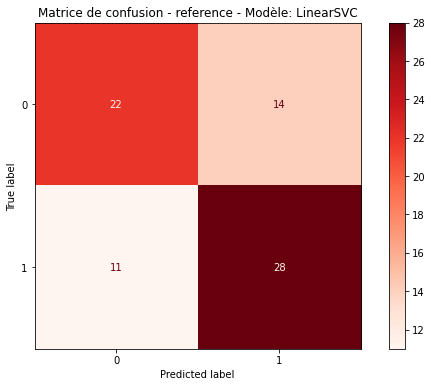

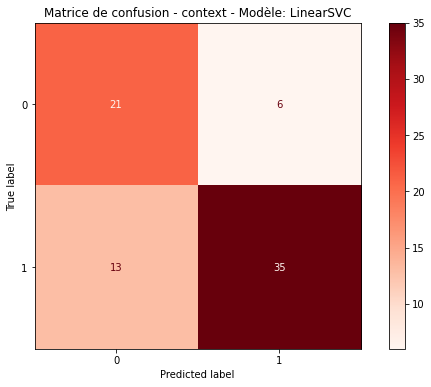


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
[('conference',), ('research',), ('url',), ('case',), ('grant',), ('vitro',), ('increase',), ('medical',), ('2018',), ('post',), ('science',), ('funding',), ('non',), ('say',), ('public',), ('coronavirus',), ('oral',), ('eurekamag',), ('drug',), ('transmission',), ('scientist',), ('url url url',), ('2014',), ('disease',), ('year',), ('article',), ('finding',), ('twice',), ('program',), ('site',), ('work',), ('rise',), ('based',), ('discover',), ('read',), ('moon',), ('know',), ('planet',), ('look',), ('despite',), ('future',), ('support',), ('key',), ('blog',), ('speaking',), ('blood',), ('side',), ('bone',), ('service',), ('social',)]

--- Top features pour la classe 'reference' ---
[('url',), ('symptom',), ('increase',), ('journal',), ('april',), ('great',), ('use',), ('transmission',), ('may',), ('level',), ('latest',), ('eurekamag',), ('rise',), ('cell',), ('helped',), ('ptsd',), ('scie

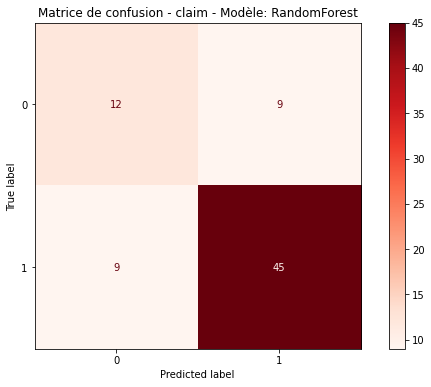

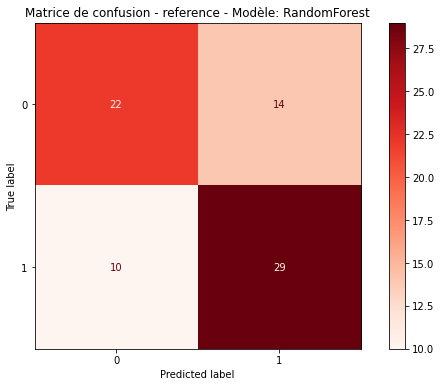

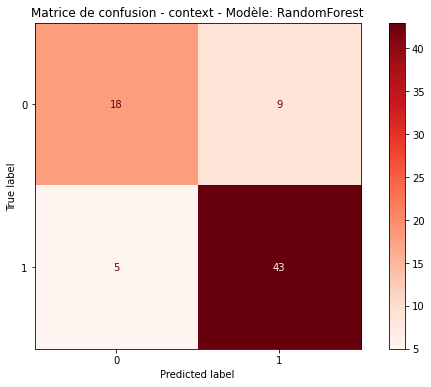


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
[('url',), ('science',), ('research',), ('study',), ('conference',), ('increase',), ('scientist',), ('url url',), ('eurekamag',), ('science url',), ('support',), ('new',), ('cancer',), ('april',), ('people',), ('could',), ('non',), ('change',), ('article',), ('vitro',), ('future',), ('one',), ('transmission',), ('evidence',), ('help',), ('find',), ('medical',), ('planet',), ('research url',), ('blog',), ('based',), ('case',), ('five',), ('funding',), ('woman',), ('2018',), ('brain',), ('according',), ('know',), ('first',), ('health',), ('structure',), ('rise',), ('treatment',), ('culture',), ('another',), ('relationship',), ('risk',), ('lead',), ('earth',)]

--- Top features pour la classe 'reference' ---
[('url',), ('science',), ('support',), ('url url',), ('study',), ('increase',), ('rise',), ('scientist',), ('help',), ('april',), ('eurekamag',), ('life',), ('research',), ('moon',), ('fiv

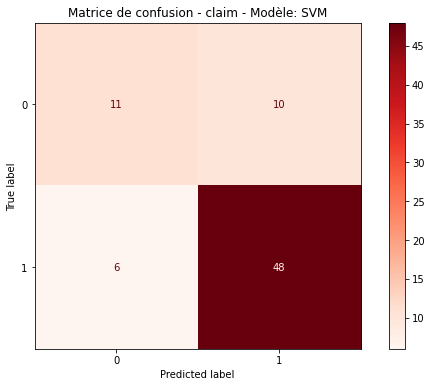

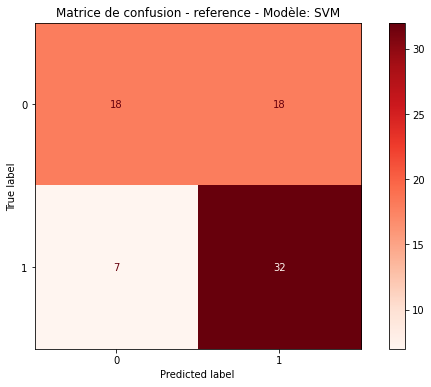

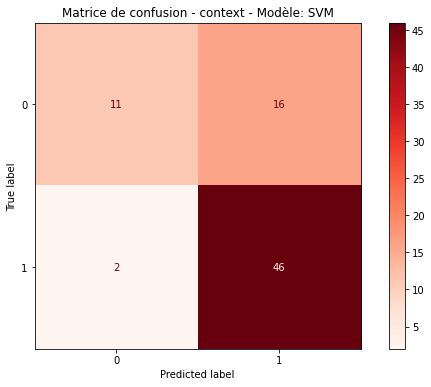


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
Pas d'attribut de feature importance pour SVC

--- Top features pour la classe 'reference' ---
Pas d'attribut de feature importance pour SVC

--- Top features pour la classe 'context' ---
Pas d'attribut de feature importance pour SVC

CV F1-Score (micro): 0.8992 ± 0.0691

 accuracy : 0.7331 ± 0.0691
Hamming Loss: 0.26222222222222225

Optimisation de Naive Bayes
Fitting 10 folds for each of 6 candidates, totalling 60 fits

Meilleurs paramètres: {'estimator__alpha': 1.0, 'estimator__fit_prior': True}

Performance sur le TEST SET:
              precision    recall  f1-score   support

       claim       0.86      0.81      0.84        54
   reference       0.60      0.62      0.61        39
     context       0.68      1.00      0.81        48

   micro avg       0.72      0.82      0.77       141
   macro avg       0.71      0.81      0.75       141
weighted avg       0.73      0.82      0.76

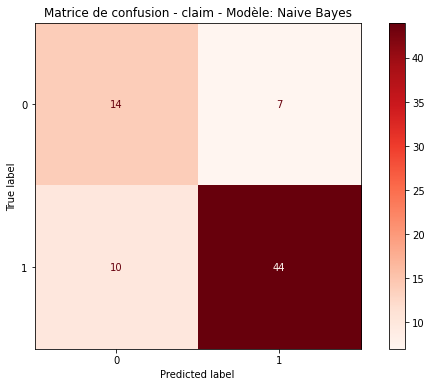

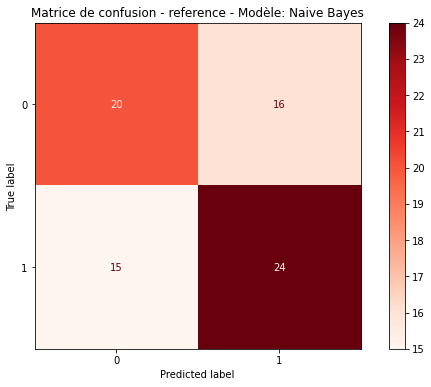

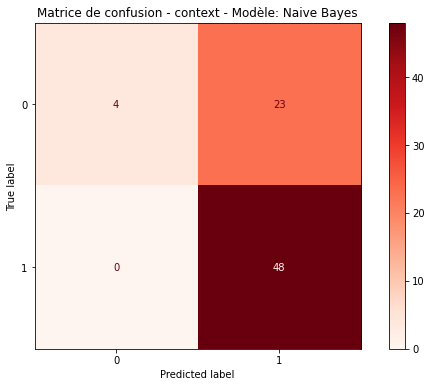


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
Pas d'attribut de feature importance pour MultinomialNB

--- Top features pour la classe 'reference' ---
Pas d'attribut de feature importance pour MultinomialNB

--- Top features pour la classe 'context' ---
Pas d'attribut de feature importance pour MultinomialNB

CV F1-Score (micro): 0.8601 ± 0.0802

 accuracy : 0.6101 ± 0.0802
Hamming Loss: 0.31555555555555553

Optimisation de k-NN
Fitting 10 folds for each of 12 candidates, totalling 120 fits

Meilleurs paramètres: {'estimator__metric': 'cosine', 'estimator__n_neighbors': 7, 'estimator__weights': 'distance'}

Performance sur le TEST SET:
              precision    recall  f1-score   support

       claim       0.86      0.69      0.76        54
   reference       0.57      0.64      0.60        39
     context       0.67      0.96      0.79        48

   micro avg       0.69      0.77      0.73       141
   macro avg       0.70      0.76

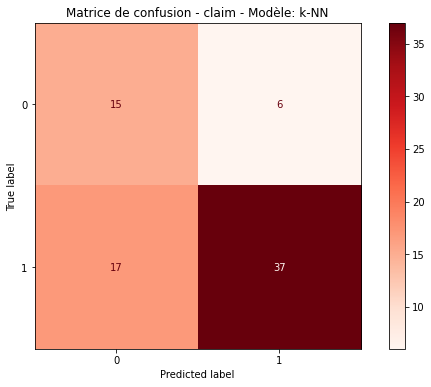

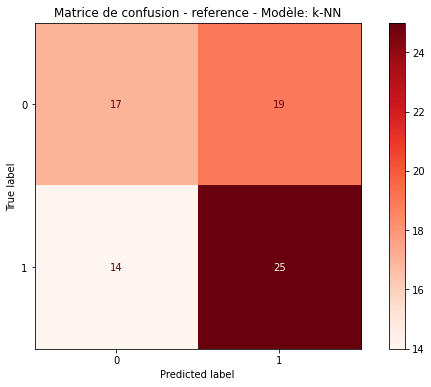

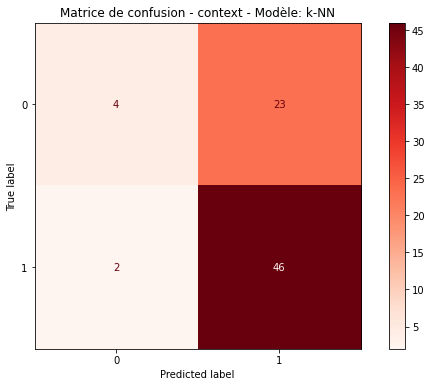


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
Pas d'attribut de feature importance pour KNeighborsClassifier

--- Top features pour la classe 'reference' ---
Pas d'attribut de feature importance pour KNeighborsClassifier

--- Top features pour la classe 'context' ---
Pas d'attribut de feature importance pour KNeighborsClassifier

CV F1-Score (micro): 0.8615 ± 0.0763

 accuracy : 0.6868 ± 0.0763
Hamming Loss: 0.36

Optimisation de Logistic Regression
Fitting 10 folds for each of 6 candidates, totalling 60 fits

Meilleurs paramètres: {'estimator__C': 10, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}

Performance sur le TEST SET:
              precision    recall  f1-score   support

       claim       0.82      0.83      0.83        54
   reference       0.70      0.72      0.71        39
     context       0.85      0.81      0.83        48

   micro avg       0.79      0.79      0.79       141
   macro avg       0.79   

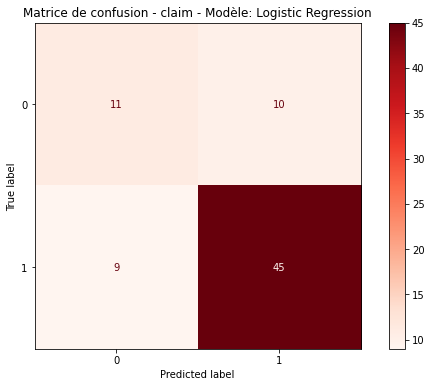

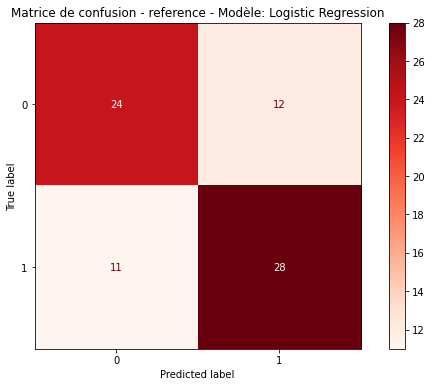

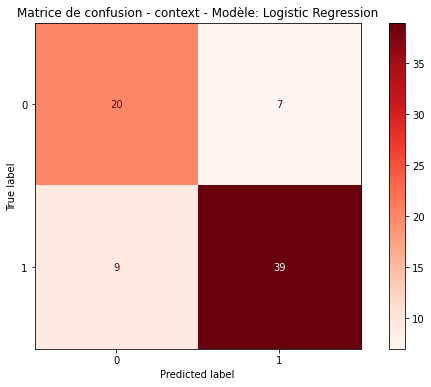


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
[('conference',), ('case',), ('vitro',), ('research',), ('increase',), ('non',), ('post',), ('2018',), ('grant',), ('url',), ('science',), ('medical',), ('2014',), ('work',), ('url url url',), ('oral',), ('drug',), ('service',), ('side',), ('eurekamag',), ('read',), ('transmission',), ('twice',), ('article',), ('funding',), ('say',), ('public',), ('finding',), ('year',), ('program',), ('support',), ('disease',), ('scientist',), ('based',), ('rise',), ('stop',), ('despite',), ('coronavirus',), ('discover',), ('moon',), ('bone',), ('want',), ('planet',), ('treatment',), ('key',), ('new',), ('science url',), ('speaking',), ('health url',), ('effect',)]

--- Top features pour la classe 'reference' ---
[('url',), ('deal',), ('symptom',), ('increase',), ('latest',), ('action',), ('april',), ('like',), ('journal',), ('great',), ('use',), ('ocean',), ('eurekamag',), ('scientist',), ('cell',), ('may

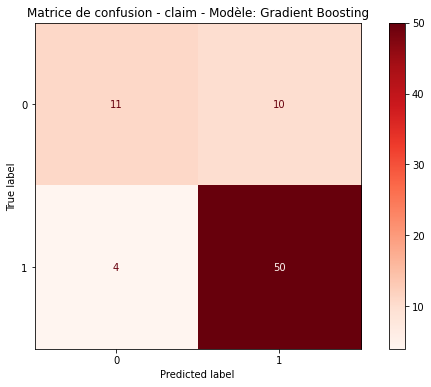

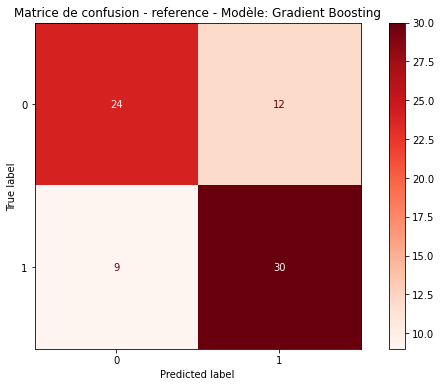

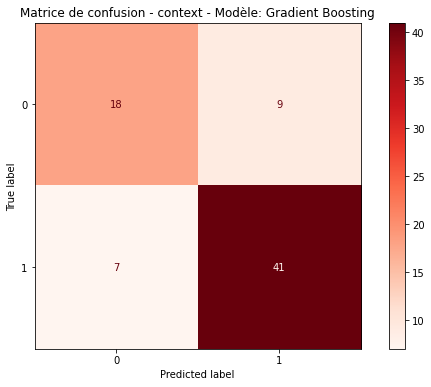


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
[('url',), ('science',), ('research',), ('conference',), ('support',), ('scientist',), ('eurekamag',), ('vitro',), ('increase',), ('could',), ('based',), ('non',), ('study',), ('april',), ('article',), ('funding',), ('2018',), ('culture',), ('read',), ('risk',), ('post',), ('rise',), ('new',), ('analysis',), ('blog',), ('2014',), ('future',), ('cause',), ('moon',), ('discover',), ('look',), ('twice',), ('love',), ('cancer',), ('first',), ('take',), ('side',), ('work',), ('relationship',), ('another',), ('people',), ('say',), ('find',), ('disease',), ('depression',), ('see',), ('oral',), ('latest',), ('url url url',), ('change',)]

--- Top features pour la classe 'reference' ---
[('url',), ('science',), ('scientist',), ('rise',), ('eurekamag',), ('increase',), ('could',), ('five',), ('conference',), ('building',), ('program',), ('april',), ('much',), ('study',), ('research url',), ('article'

In [25]:
# ------------------------------------------------------------
# SOLUTION FINALE POUR CLASSIFICATION MULTI-LABEL
# Avec gestion du déséquilibre et validation croisée adaptée
# ------------------------------------------------------------
"""le Hamming loss est une métrique utilisée en classification multi-label (comme dans ton cas), 
et elle mesure la proportion de mauvaises prédictions de labels par rapport au nombre total de labels.

"""

import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from scipy.sparse import vstack
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# 1. Préparation des données

stop_words = set(stopwords.words('english'))
custom_stop_words = {"rt", "co", "amp", "via"}
#negations = {"not", "no", "nor", "neither", "never", "none"}
stop_words = stop_words #- negations
stop_words.update(custom_stop_words)
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    #tweet = re.sub(r"@\w+|\W", " ", tweet)
    tweet = re.sub(r"(https?://\S+)", " URL ", tweet)
    tweet = tweet.lower()
    tokens = word_tokenize(tweet)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# 2. Chargement et préparation
sci_df = df[df['science_related'] == 1].copy()
sci_df['cleaned_text'] = sci_df['text'].apply(preprocess_tweet)

# 3. Création des cibles multi-labels
y = sci_df[['scientific_claim', 'scientific_reference', 'scientific_context']].values
X = sci_df['cleaned_text']



# 4. Vectorisation
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=8000,
    min_df=3,
    max_df=0.85
)
X_vec = vectorizer.fit_transform(X)

feature_names = np.array(vectorizer.get_feature_names_out())

# 5. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, 
    test_size=0.2,
    random_state=42
)

# 6. Rééchantillonnage manuel adapté au multi-label
def multilabel_oversample(X, y, random_state=None):
    np.random.seed(random_state)
    
    # Compter les occurrences de chaque combinaison de labels
    unique_labels, counts = np.unique(y, axis=0, return_counts=True)
    max_count = max(counts)
    
    resampled_X = []
    resampled_y = []
    
    for label_combination, count in zip(unique_labels, counts):
        indices = np.where((y == label_combination).all(axis=1))[0]
        
        # Suréchantillonnage seulement pour les classes minoritaires
        if count < max_count:
            n_to_add = max_count - count
            selected = np.random.choice(indices, size=n_to_add, replace=True)
            
            resampled_X.append(X[selected])
            resampled_y.append(y[selected])
    
    if resampled_X:
        return vstack([X] + resampled_X), np.vstack([y] + resampled_y)
    return X, y

X_train_res, y_train_res = multilabel_oversample(X_train, y_train, random_state=42)

# 7. Configuration des modèles
models = {
    "LinearSVC": {
        "model": LinearSVC(dual=False, class_weight='balanced'),
        "params": {
            'estimator__C': [0.1, 1],
            'estimator__penalty': ['l1', 'l2']
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(class_weight='balanced_subsample'),
        "params": {
            'estimator__n_estimators': [100],
            'estimator__max_depth': [10, None],
            'estimator__min_samples_split': [5, 10]
        }
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            'estimator__C': [0.1, 1, 10],
            'estimator__kernel': ['linear', 'rbf']
        }
    },
    "Naive Bayes": {
        "model": MultinomialNB(),
        "params": {
            'estimator__alpha': [0.1, 0.5, 1.0],
            'estimator__fit_prior': [True, False]
        }
    },
    "k-NN": {
        "model": KNeighborsClassifier(),
        "params": {
            'estimator__n_neighbors': [3, 5, 7],
            'estimator__weights': ['uniform', 'distance'],
            'estimator__metric': ['euclidean', 'cosine']
        }
    },
    
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            'estimator__C': [0.1, 1, 10],
            'estimator__penalty': ['l1', 'l2'],
            'estimator__solver': ['liblinear']
        }
    },

    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            'estimator__n_estimators': [50, 100],
            'estimator__learning_rate': [0.01, 0.1],
            'estimator__max_depth': [3, 5]
        }
    }
    
}

# 8. Évaluation avec KFold standard (adapté au multi-label)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, config in models.items():
    print(f"\n{'='*60}")
    print(f"Optimisation de {name}")
    print(f"{'='*60}")
    
    model = MultiOutputClassifier(config['model'])
    
    grid = GridSearchCV(
        model,
        param_grid=config['params'],
        cv=kf,
        scoring='f1_micro',
        n_jobs=-1,
        verbose=1
    )
    
    # Entraînement sur données rééchantillonnées
    grid.fit(X_train_res, y_train_res)
    
    # Évaluation sur test set original
    y_pred = grid.predict(X_test)
    
    print(f"\nMeilleurs paramètres: {grid.best_params_}")
    print("\nPerformance sur le TEST SET:")
    print(classification_report(
        y_test, y_pred,
        target_names=['claim', 'reference', 'context'],
        zero_division=0
    ))
    
    ###################################################################
    
    # Afficher une matrice de confusion
    
    # Noms des étiquettes pour chaque colonne
    label_names = ['claim', 'reference', 'context']

    # Boucle sur chaque label (chaque colonne)
    for i, label in enumerate(label_names):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Reds')
        plt.title(f"Matrice de confusion - {label} - Modèle: {name}")
        plt.show()
    
    
    
    ###################################################################
    ###################################################################
    
    #Extraire les features les plus important
    
    nombre_de_features = 50
    
    print(f"\nTop", nombre_de_features, "features importantes pour le modèle: {name}")

    # Récupérer le meilleur modèle entraîné
    best_model = grid.best_estimator_

    # Pour chaque sortie (label multi-label), extraire les features importantes
    for i, label in enumerate(['claim', 'reference', 'context']):
        print(f"\n--- Top features pour la classe '{label}' ---")

        estimator = best_model.estimators_[i]  # modèle pour ce label

        if hasattr(estimator, 'coef_'):
            # Pour LinearSVC ou LogisticRegression
            coefs = estimator.coef_.flatten()
            top_indices = np.argsort(np.abs(coefs))[(-1*nombre_de_features):][::-1]
            top_features = feature_names[top_indices]
            #print(list(zip(top_features, coefs[top_indices])))
            print(list(zip(top_features)))


        elif hasattr(estimator, 'feature_importances_'):
            # Pour RandomForest, GradientBoosting
            importances = estimator.feature_importances_
            top_indices = np.argsort(importances)[(-1*nombre_de_features):][::-1]
            top_features = feature_names[top_indices]
            #print(list(zip(top_features, importances[top_indices])))
            print(list(zip(top_features)))

        else:
            print(f"Pas d'attribut de feature importance pour {type(estimator).__name__}")

    
    
    
    ####################################################################
    
    # Scores de validation croisée
    cv_scores = []
    cv_score = []
    for train_idx, test_idx in kf.split(X_train_res):
        X_train_fold, X_val_fold = X_train_res[train_idx], X_train_res[test_idx]
        y_train_fold, y_val_fold = y_train_res[train_idx], y_train_res[test_idx]
        
        model.set_params(**grid.best_params_)
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        
        # Calcul de l'accuracy au lieu du F1-score
        cv_scores.append(accuracy_score(y_val_fold, y_pred_fold))
        cv_score.append(f1_score(y_val_fold, y_pred_fold, average='micro'))
    
    print(f"\nCV F1-Score (micro): {np.mean(cv_score):.4f} ± {np.std(cv_scores):.4f}")
    print(f"\n accuracy : {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    from sklearn.metrics import hamming_loss
    print("Hamming Loss:", hamming_loss(y_test, y_pred))


# Discussion

# Conclusion